# Data Exploration for NBA 2014-2015 Shot Log Dataset 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as sm

import sklearn

from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

import xgboost

color = sns.color_palette()

In [2]:
df_nba = pd.read_csv("./shot_logs.csv")

In [3]:
df_nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
GAME_ID                       128069 non-null int64
MATCHUP                       128069 non-null object
LOCATION                      128069 non-null object
W                             128069 non-null object
FINAL_MARGIN                  128069 non-null int64
SHOT_NUMBER                   128069 non-null int64
PERIOD                        128069 non-null int64
GAME_CLOCK                    128069 non-null object
SHOT_CLOCK                    122502 non-null float64
DRIBBLES                      128069 non-null int64
TOUCH_TIME                    128069 non-null float64
SHOT_DIST                     128069 non-null float64
PTS_TYPE                      128069 non-null int64
SHOT_RESULT                   128069 non-null object
CLOSEST_DEFENDER              128069 non-null object
CLOSEST_DEFENDER_PLAYER_ID    128069 non-null int64
CLOSE_DEF_DIST                128069 non-null

In [4]:
df_nba.shape

(128069, 21)

In [5]:
df_nba.head(5)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [6]:
df_nba.GAME_ID.nunique()

904

# Data Preprocessing

## Handling Null Entries

Text(0.5, 1.0, 'Number of Missing Values by Column')

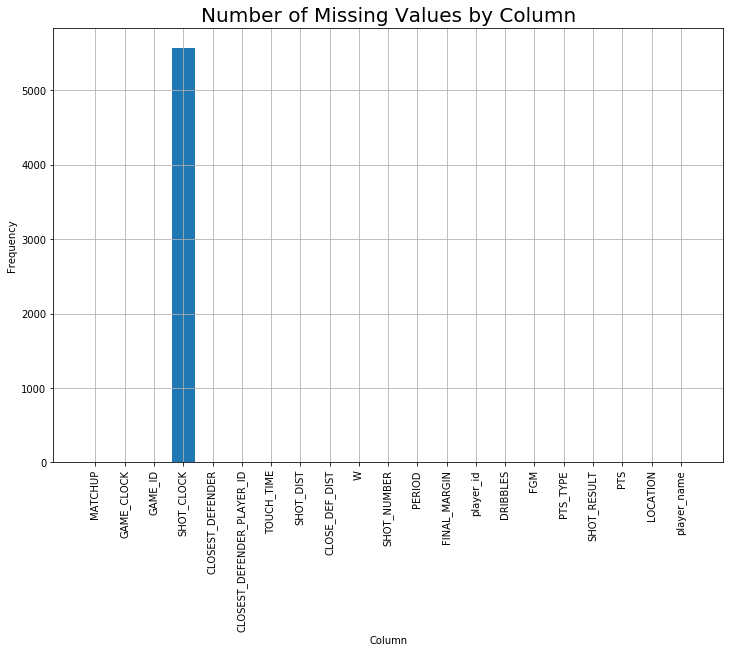

In [7]:
nan_counts = {}
for col in df_nba.columns:
    nan_counts[col] = df_nba[col].isna().sum()
    
plt.figure(figsize=(12, 8))
plt.bar(nan_counts.keys(), nan_counts.values())
plt.xticks(rotation=90)
plt.grid()
plt.xlabel('Column')
plt.ylabel('Frequency')
plt.title('Number of Missing Values by Column', fontsize=20)

It appears that the SHOT_CLOCK column is the only column that has NaN entries. 



Text(0.5, 1.0, 'Histogram of Seconds Left on the Shot Clock on Shot')

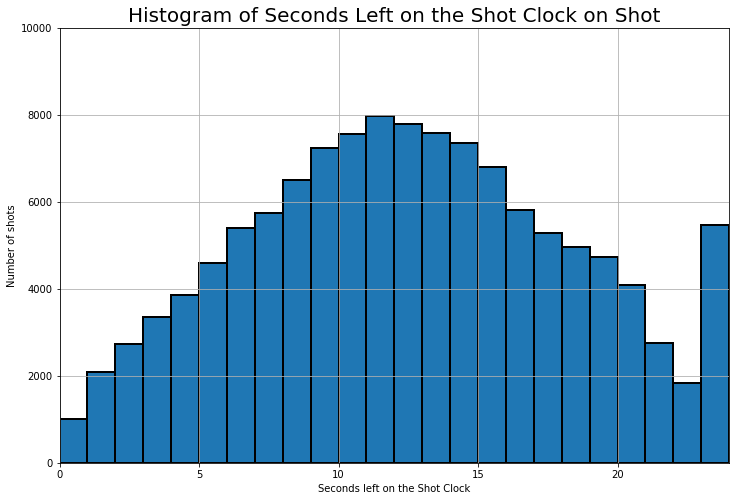

In [8]:
plt.figure(figsize=(12, 8))
df_nba['SHOT_CLOCK'].hist(bins=24, edgecolor='black', linewidth=2)
plt.xlim([0, 24])
plt.ylim([0, 10000])
plt.xlabel('Seconds left on the Shot Clock')
plt.ylabel('Number of shots')
plt.title('Histogram of Seconds Left on the Shot Clock on Shot', fontsize=20)

One explanation for the shot clock variable being NaN is when the game clock for the quarter is less than the full 24 seconds of the shot clock. We are going to impute the NaNs that follow this case. 

In [9]:
df_nba.GAME_CLOCK.head(5)

0     1:09
1     0:14
2     0:00
3    11:47
4    10:34
Name: GAME_CLOCK, dtype: object

First we should convert this information into raw seconds for easier computation. 

In [10]:
df_nba['GAME_CLOCK'] = df_nba['GAME_CLOCK'].apply(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1]))
 
df_nba[df_nba['SHOT_CLOCK'].isnull() & (df_nba['GAME_CLOCK'] <= 24)].shape

(3554, 21)

It appears that ~60% of the NaNs for the "SHOT_CLOCK" column can be explained by when the "GAME_CLOCK" is less than 24 seconds. This might happen when the SHOT_CLOCK is 24, but the GAME_CLOCK is less than 24, leading to the GAME_CLOCK being the constraint on the time left to shoot and the SHOT_CLOCK being turned off. 

We know this is the case because the number of shots where SHOT_CLOCK == GAME_CLOCK is only 10, as seen down below. We know that this value should be much much more.

Therefore, we will impute these NaNs with the "GAME_CLOCK" value if the "GAME_CLOCK" is less than 24.

In [11]:
df_nba[df_nba.SHOT_CLOCK == df_nba.GAME_CLOCK].shape

(10, 21)

In [12]:
shot_query = df_nba['SHOT_CLOCK'].isnull() & (df_nba['GAME_CLOCK'] <= 24)
df_nba.loc[shot_query, 'SHOT_CLOCK'] = df_nba[shot_query]['GAME_CLOCK']

We are left with 2000 NaNs in the SHOT_CLOCK field, so we will remove the rest of the rows. 

In [13]:
df_nba[df_nba.SHOT_CLOCK.isnull()].shape

(2013, 21)

In [14]:
df_nba = df_nba[~df_nba.SHOT_CLOCK.isnull()]

## Handling Negative Values

None of the numeric columns except for final margin should have negative numbers.

Text(0.5, 1.0, 'Number of Negative Values by Column')

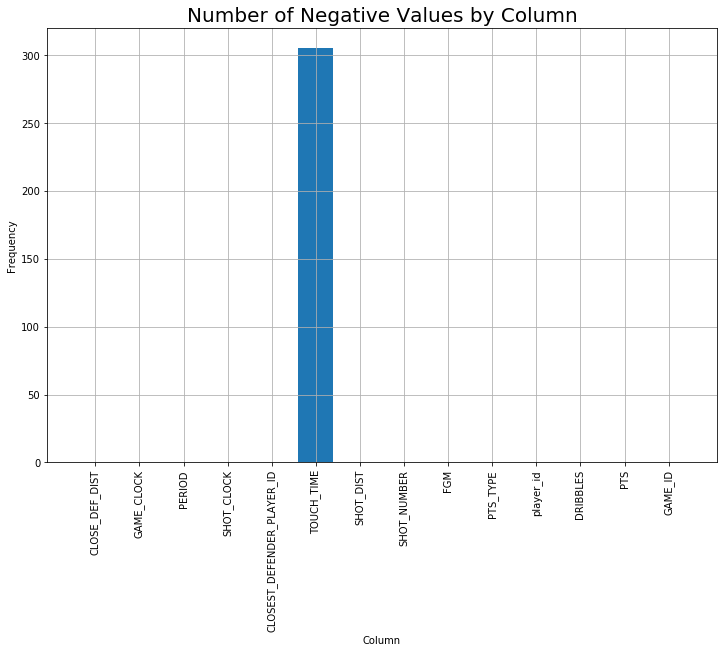

In [15]:
neg_counts = {}
for col in df_nba.columns:
    if col == "FINAL_MARGIN":
        continue
    if df_nba[col].dtype != "object":
        neg_counts[col] = df_nba[col].apply(lambda x: x < 0).sum()
    
plt.figure(figsize=(12, 8))
plt.bar(neg_counts.keys(), neg_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Frequency')
plt.grid()
plt.title('Number of Negative Values by Column', fontsize=20)

It seems that only the TOUCH_TIME column has ~300 negative values, which doesn't make any sense. Before we throw out the rows with this value, let's see if we can impute this value by analyzing the distribution of touch times of the entire distribution, and compare it to the distribution of negative touch times. 

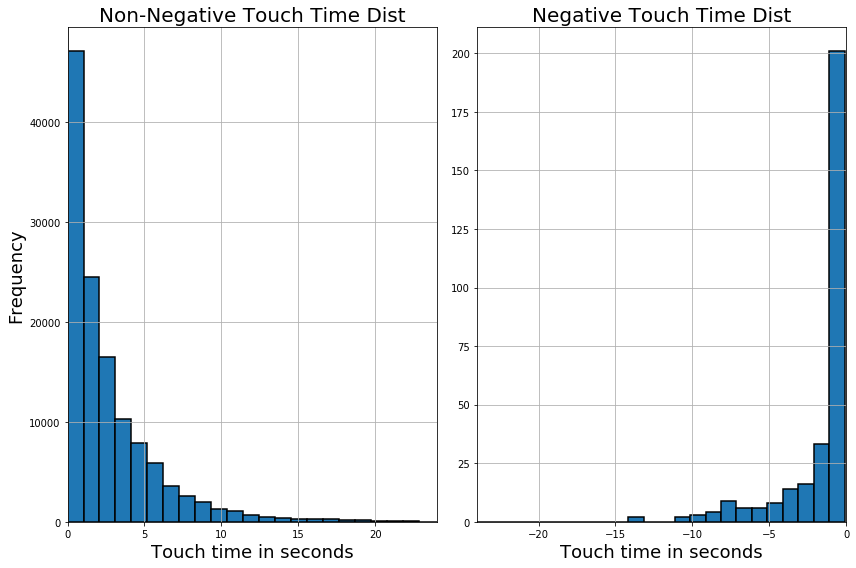

In [16]:
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

df_nba[df_nba.TOUCH_TIME >= 0].TOUCH_TIME.hist(bins=24, linewidth=1.5, edgecolor='black', ax=ax1)
min_value = min(df_nba[df_nba.TOUCH_TIME < 0].TOUCH_TIME)
df_nba[df_nba.TOUCH_TIME < 0].TOUCH_TIME.hist(bins=-1*int(min_value), linewidth=1.5, edgecolor='black', ax=ax2)

ax1.set_xlim([0, 24])
ax1.set_xlabel('Touch time in seconds', fontsize=18)
ax1.set_ylabel('Frequency', fontsize=18)
ax1.set_title('Non-Negative Touch Time Dist', fontsize=20)

ax2.set_xlim([-24, 0])
ax2.set_xlabel('Touch time before shot in seconds')
ax2.set_xlabel('Touch time in seconds', fontsize=18)
ax2.set_title('Negative Touch Time Dist', fontsize=20)

plt.tight_layout()

It appears that the negative valued touch times closely mirror the distribution of the positive valued TOUCH_TIMEs. Therefore, we can flip the sign of the negative values because it was probably a recording mistake due to user error inserting an extra negative sign to the actual TOUCH_TIME

In [17]:
touch_query = df_nba.TOUCH_TIME < 0
df_nba.loc[touch_query, 'TOUCH_TIME'] = -1*df_nba.loc[touch_query, 'TOUCH_TIME']

/home/alexdai/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


## Handling Non-sensical Values

Now we need to get rid of rows that have values much too small or too large to make any sense, thus indicating possible recording error

In [18]:
high_lows = {}
for col in df_nba.columns:
    if df_nba[col].dtype != "object":
        high_lows[col] = [min(df_nba[col]), max(df_nba[col])]
    
# prints out the min and max values for the specific column
print(high_lows)

{'CLOSE_DEF_DIST': [0.0, 53.2], 'GAME_CLOCK': [0, 720], 'PERIOD': [1, 7], 'SHOT_CLOCK': [0.0, 24.0], 'CLOSEST_DEFENDER_PLAYER_ID': [708, 530027], 'TOUCH_TIME': [0.0, 100.5], 'SHOT_DIST': [0.0, 47.2], 'SHOT_NUMBER': [1, 38], 'FGM': [0, 1], 'FINAL_MARGIN': [-53, 53], 'player_id': [708, 204060], 'DRIBBLES': [0, 32], 'PTS_TYPE': [2, 3], 'PTS': [0, 3], 'GAME_ID': [21400001, 21400908]}


It appears that TOUCH_TIME has an entry of 100.5, which isn't possible since the maximum TOUCH_TIME should be the shot clock length, 24 seconds. 

In [19]:
df_nba[df_nba.TOUCH_TIME > 24].TOUCH_TIME

5574     100.5
34112     24.5
34187     24.1
87255     24.9
94204     24.4
Name: TOUCH_TIME, dtype: float64

Toss out the 5 rows with TOUCH_TIME's greater than 24. 

In [20]:
df_nba = df_nba[df_nba.TOUCH_TIME <= 24]

## Cleaning up column values

The MATCHUP column seems to have many interesting variables, such as the teams and the time all in one string. Therefore, we will split these up into separate columns for later use

In [21]:
df_nba.MATCHUP.head(5)

0    MAR 04, 2015 - CHA @ BKN
1    MAR 04, 2015 - CHA @ BKN
2    MAR 04, 2015 - CHA @ BKN
3    MAR 04, 2015 - CHA @ BKN
4    MAR 04, 2015 - CHA @ BKN
Name: MATCHUP, dtype: object

In [22]:
def parse_matchup(row):
    """
    Converts the MATCHUP field into 3 fields, date, away team, and home team. 
    
    :row: row in the df.
    
    :return: tuple of 3 columns, date, away team, and home team. 
    """
    matchup = row['MATCHUP'].split('-')
    date = matchup[0].strip()
    if '@' in matchup[1]:
        teams = matchup[1].split('@')
    else:
        teams = matchup[1].split('vs.')
    
    ret_date = pd.to_datetime(date)
    ret_away = teams[0].strip()
    ret_home = teams[1].strip()
    
    return (ret_date, ret_away, ret_home)

In [23]:
# This line takes a while
df_nba[['DATE', 'AWAY_TEAM', 'HOME_TEAM']] = df_nba.apply(parse_matchup, axis=1).apply(pd.Series)

## Removing Extraneous Rows

There's a lot of redundant columns in this dataset. 

FGM and SHOT_RESULT are the exact same
PTS is just SHOT_RESULT * SHOT_TYPE
MATCHUP is now redundant now that we've broken it up into 3 columns

In [24]:
del(df_nba['FGM'])
del(df_nba['PTS'])
del(df_nba['MATCHUP'])

## Converting SHOT_RESULT and WIN into 0/1 variables

In [25]:
df_nba['SHOT_RESULT'] = df_nba.SHOT_RESULT.map(dict(made=1, missed=0))

df_nba['W'] = df_nba.W.map(dict(W=1, L=0))

# Data Processing and Analysis

### Distributions
First we will look at the distributions of some of the features. 

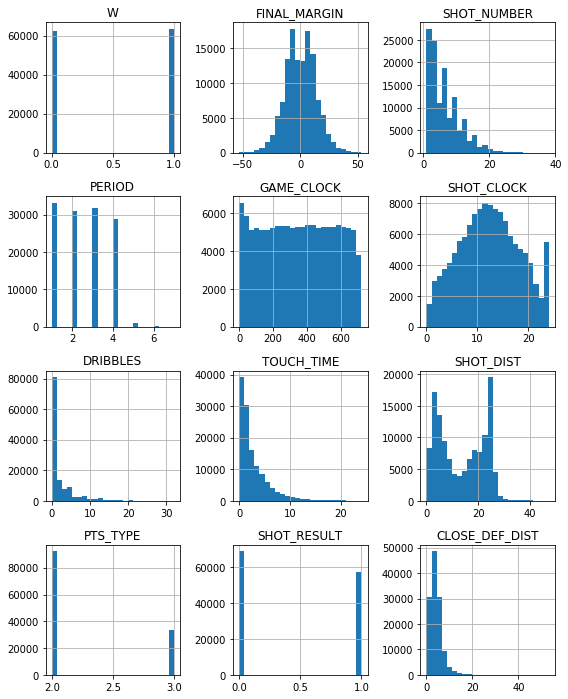

In [26]:
plt.figure(figsize=(8, 12))
df_heatmap = df_nba[['W', 'FINAL_MARGIN', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSE_DEF_DIST']]

for num, feature in enumerate(df_heatmap.columns):
    ax = plt.subplot(5, 3, num+1)
    df_heatmap[feature].hist(bins=24, ax=ax)
    ax.set_title(feature)
    
plt.tight_layout()

### Heatmap

Now we will analyze the relationships between each of the features by creating a correlation heatmap between all of the features. 

Text(0.5, 1.0, 'Correlation Heatmap')

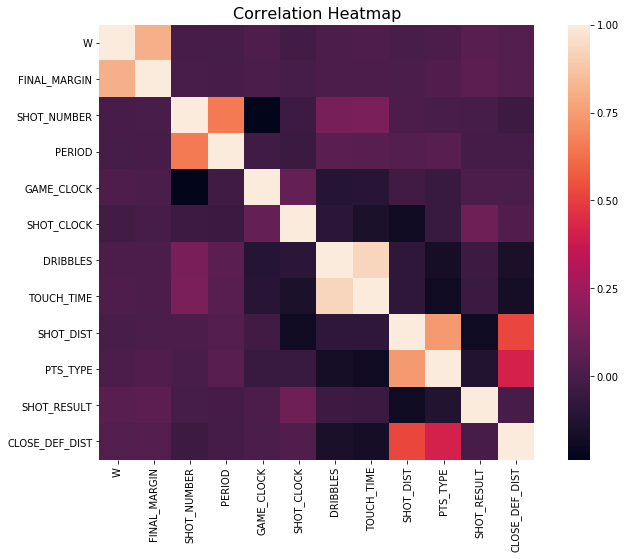

In [27]:
df_corr = df_heatmap.corr()

ax = plt.figure(figsize=(12, 8)).gca().set_aspect('equal')
sns.heatmap(df_corr, ax=ax)
plt.title('Correlation Heatmap', fontsize=16)

It seems out of all of the features, the time left on the shot clock seems to have the highest correlation with the final shot result. 

Text(0.5, 1.0, 'Shot Percentage by Seconds left on Shot Clock')

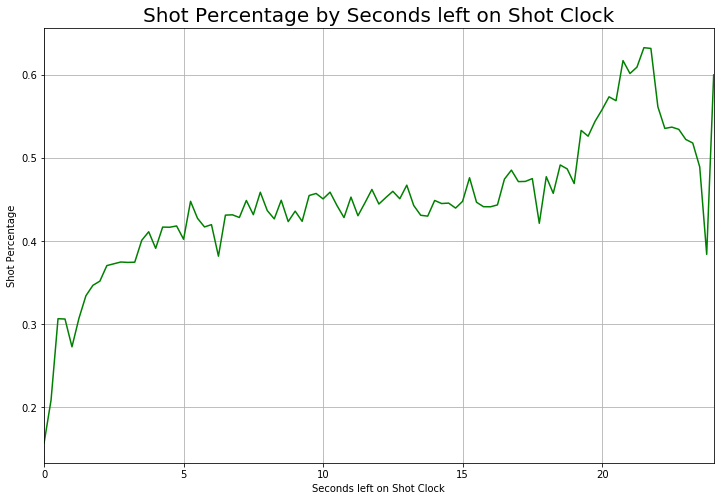

In [64]:
plt.figure(figsize=(12, 8))
bins = np.arange(0, 24.25, 0.25)
binned = np.digitize(df_nba.SHOT_CLOCK, bins)
df_bins = pd.DataFrame()
df_bins['SHOT_RESULT'] = df_nba['SHOT_RESULT']
df_bins['bins'] = binned
a = df_bins.groupby(['bins'])['SHOT_RESULT'].mean()
a.index = np.arange(0, 24.25, 0.25)
plt.plot(a, color='green')
plt.xlabel('Seconds left on Shot Clock')
plt.ylabel('Shot Percentage')
plt.grid()
plt.xlim([0, 24])
plt.title('Shot Percentage by Seconds left on Shot Clock', fontsize=20)

As the seconds on the shot clock decrease, the field goal percentage decreases. This is probably due to the fact that as the shot clock winds down, there is more pressure for the shooter to put up a shot. Also, there is a higher chance that the shot taken with a few seconds on the shot clock will be against a set defense with all 5 players in play. The reason that the field goal percentage is so high when there are a lot of seconds left is because a lot of shots made in transition off of a rebound or a steal are made very early on in the shot clock. 

### Shot Distance vs. Closest Defender Distance
Now we will analyze the relationship between SHOT_DISTANCE and CLOSEST_DEFENDER_DISTANCE. 

/home/alexdai/.local/lib/python3.5/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/alexdai/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/alexdai/.local/lib/python3.5/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


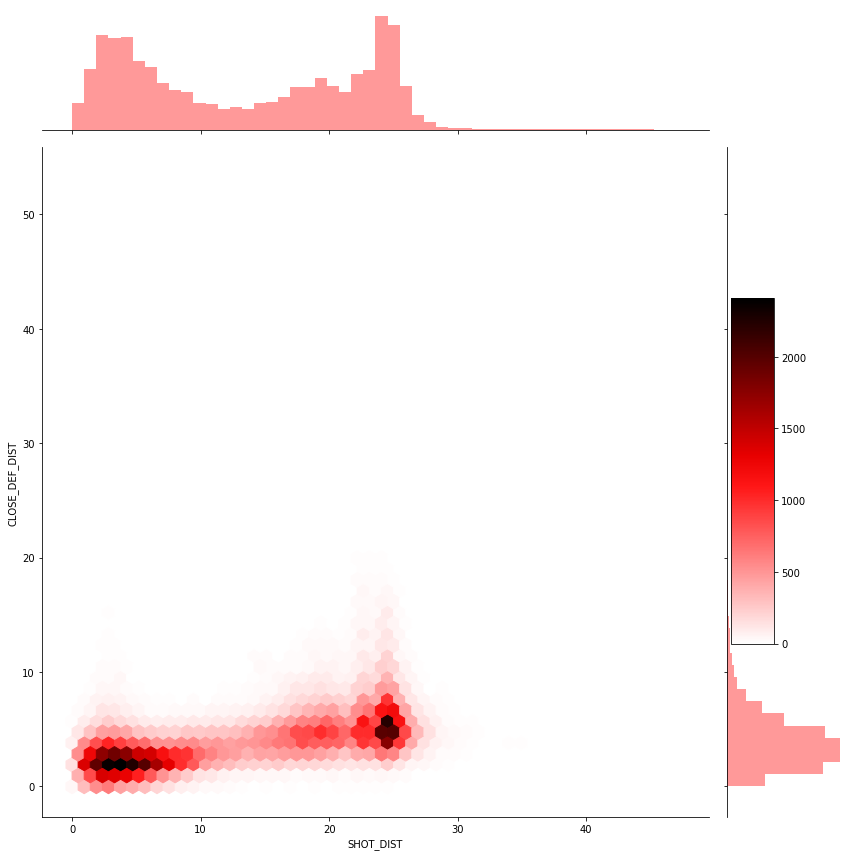

In [61]:
hexplot = sns.jointplot(x="SHOT_DIST", y="CLOSE_DEF_DIST", data=df_nba, color='red', kind='hex', size=12)
# shrink fig so cbar is visible
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
# make new ax object for the cba 
cbar_ax = hexplot.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
# plt.title('Shot Distance vs. Closest Defender Distance', fontsize=20)
plt.colorbar(cax=cbar_ax)
plt.tight_layout()
plt.show()

The hexplot shows that most shot are either layups (0-5 feet) or 3-pt shots (~22ft+). Layups are defended at a much close distance than 3-pt shots. 

Our data always has a closest defender listed for every shot, however, it wouldn't make any sense to factor that in when the defender is very far away from the shooter. If the defender is a certain distance away from the shot, then we should treat it as if there was no defender at all and the shooter was able to shoot an "open" shot. 

We don't want our model to learn strange dependencies based on how far the closest defender was from the shooter if the shot is considered completely "open". Therefore, we will try factoring the closest defender distance into 4 categories (taken from https://www.NBA.com). 

(0-2 feet) Very Tightly Defended

(2-4 feet) Tightly Defended

(4-6 feet) Open

(6-10 feet) Very Open

(10 feet+) Completely Open

Text(0.5, 1.0, 'Shot Percentage by Shot Distance')

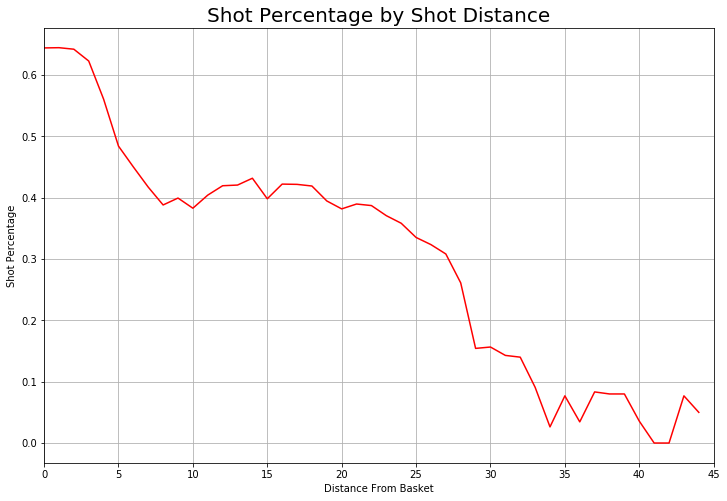

In [63]:
plt.figure(figsize=(12, 8))
bins = np.arange(0, 45, 1)
binned = np.digitize(df_nba.SHOT_DIST, bins)
df_bins = pd.DataFrame()
df_bins['SHOT_RESULT'] = df_nba['SHOT_RESULT']
df_bins['bins'] = binned
a = df_bins.groupby(['bins'])['SHOT_RESULT'].mean()
a.index = np.arange(0, 45, 1)
plt.plot(a, color='red')
plt.xlabel('Distance From Basket')
plt.ylabel('Shot Percentage')
plt.grid()
plt.xlim([0, 45])
plt.title('Shot Percentage by Shot Distance', fontsize=20)

Text(0.5, 1.0, 'Shot Percentage by Distance from Closest Defender')

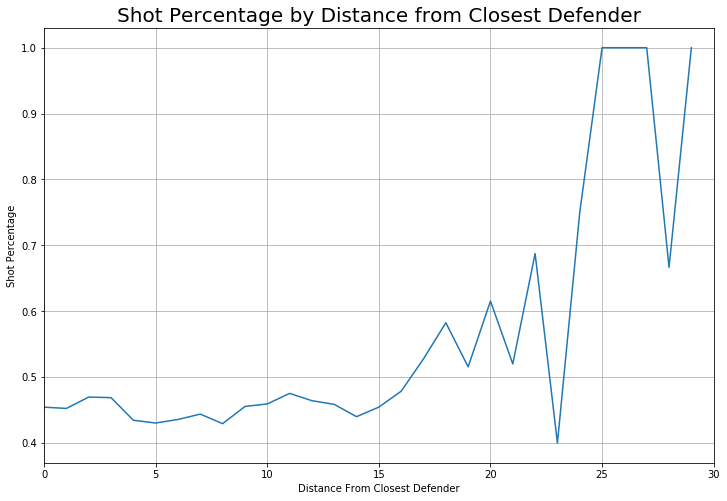

In [31]:
plt.figure(figsize=(12, 8))
bins = np.arange(0, 30, 1)
binned = np.digitize(df_nba.CLOSE_DEF_DIST, bins)
df_bins = pd.DataFrame()
df_bins['SHOT_RESULT'] = df_nba['SHOT_RESULT']
df_bins['bins'] = binned
a = df_bins.groupby(['bins'])['SHOT_RESULT'].mean()
a.index = np.arange(0, 30, 1)
plt.plot(a)
plt.xlabel('Distance From Closest Defender')
plt.ylabel('Shot Percentage')
plt.grid()
plt.xlim([0, 30])
plt.title('Shot Percentage by Distance from Closest Defender', fontsize=20)

As the distance to the closest defender increases, the shot percentage increases. It can be noticed that as the distance to the closest defender increases to higher values of 20+, the shot percentage becomes more unstable. We don't want our model to learn these dependencies (e.g. 100% make percentage at 26 feet, but a 70% make percentage at 27 feet). 

We can fix this by binning the closest defender dist variable. 

In [32]:
binned

array([2, 7, 1, ..., 5, 4, 3])

Text(0.5, 1.0, 'Shot Percentage by Distance from Closest Defender')

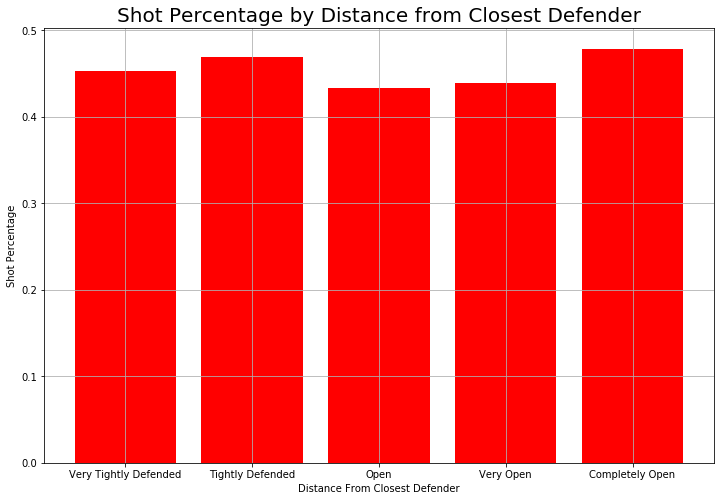

In [33]:
plt.figure(figsize=(12, 8))
bins = [0, 2, 4, 6, 10, 100]
binned = np.digitize(df_nba.CLOSE_DEF_DIST, bins)
df_bins = pd.DataFrame()
df_bins['SHOT_RESULT'] = df_nba['SHOT_RESULT']
df_bins['bins'] = binned
a = df_bins.groupby(['bins'])['SHOT_RESULT'].mean()
plt.bar(["Very Tightly Defended", "Tightly Defended", "Open", "Very Open", "Completely Open"], a, color='red')
plt.xlabel('Distance From Closest Defender')
plt.ylabel('Shot Percentage')
plt.grid()
plt.title('Shot Percentage by Distance from Closest Defender', fontsize=20)

It seems as if the distance from the closest defender affects the shot percentage slightly, if at all. 

In [34]:
def encode_defender_dist(x):
    if 0 < x <= 2:
        return "Very Tightly Defended"
    elif 2 < x <= 4:
        return "Tightly Defended"
    elif 4 < x <= 6:
        return "Open"
    elif 6 < x <= 10:
        return "Very Open"
    elif x > 10:
        return "Completely Open"
    
cat = df_nba.CLOSE_DEF_DIST.apply(encode_defender_dist)

In [35]:
df_nba = df_nba.join(pd.get_dummies(cat))

In [36]:
df_nba

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,...,player_name,player_id,DATE,AWAY_TEAM,HOME_TEAM,Completely Open,Open,Tightly Defended,Very Open,Very Tightly Defended
0,21400899,A,1,24,1,1,69,10.8,2,1.9,...,brian roberts,203148,2015-03-04,CHA,BKN,0,0,0,0,1
1,21400899,A,1,24,2,1,14,3.4,0,0.8,...,brian roberts,203148,2015-03-04,CHA,BKN,0,0,0,1,0
2,21400899,A,1,24,3,1,0,0.0,3,2.7,...,brian roberts,203148,2015-03-04,CHA,BKN,0,0,0,0,1
3,21400899,A,1,24,4,2,707,10.3,2,1.9,...,brian roberts,203148,2015-03-04,CHA,BKN,0,0,1,0,0
4,21400899,A,1,24,5,2,634,10.9,2,2.7,...,brian roberts,203148,2015-03-04,CHA,BKN,0,0,0,0,1
5,21400899,A,1,24,6,2,495,9.1,2,4.4,...,brian roberts,203148,2015-03-04,CHA,BKN,0,0,1,0,0
6,21400899,A,1,24,7,4,615,14.5,11,9.0,...,brian roberts,203148,2015-03-04,CHA,BKN,0,0,0,1,0
7,21400899,A,1,24,8,4,480,3.4,3,2.5,...,brian roberts,203148,2015-03-04,CHA,BKN,0,0,1,0,0
8,21400899,A,1,24,9,4,314,12.4,0,0.8,...,brian roberts,203148,2015-03-04,CHA,BKN,0,0,0,1,0
9,21400890,H,1,1,1,2,692,17.4,0,1.1,...,brian roberts,203148,2015-03-03,CHA,LAL,1,0,0,0,0


## One Hot Encoding the Shooting Player and Defending Player Features

In [37]:
print("Number of unique shooters in the dataset: ", df_nba.player_name.nunique())

Number of unique shooters in the dataset:  281


In [38]:
print("Number of unique defenders in the dataset: ", df_nba.CLOSEST_DEFENDER.nunique())

Number of unique defenders in the dataset:  473


In [39]:
shooters = pd.get_dummies(df_nba['player_name'], prefix="shooter_")
shooters.head(5)

,shooter__aaron brooks,shooter__aaron gordon,shooter__al farouq aminu,shooter__al horford,shooter__al jefferson,shooter__alan anderson,shooter__alan crabbe,shooter__alex len,shooter__alexis ajinca,shooter__alonzo gee,...,shooter__udonis haslem,shooter__victor oladipo,shooter__vince carter,shooter__wayne ellington,shooter__wesley johnson,shooter__wesley matthews,shooter__wilson chandler,shooter__zach lavine,shooter__zach randolph,shooter__zaza pachulia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
defenders = pd.get_dummies(df_nba['CLOSEST_DEFENDER'], prefix="defender_")
defenders.head(5)

,"defender__Acy, Quincy","defender__Adams, Jordan","defender__Adams, Steven","defender__Adrien, Jeff","defender__Afflalo, Arron","defender__Ajinca, Alexis","defender__Aldemir, Furkan","defender__Aldrich, Cole","defender__Aldridge, LaMarcus","defender__Allen, Lavoy",...,"defender__Withey, Jeff","defender__Wolters, Nate","defender__Wright, Brandan","defender__Wright, Dorell","defender__Wroten, Tony","defender__Young, James","defender__Young, Nick","defender__Young, Thaddeus","defender__Zeller, Cody","defender__Zeller, Tyler"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [41]:
df_model = df_nba[['SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST']]

df_model = df_model.join(shooters).join(defenders)

# Dimensionality Reduction

In [42]:
# Scaling all features between 0-1

for col in df_model.columns:
    df_model[col] = (df_model[col]-np.min(df_model[col]))/(np.max(df_model[col]) - np.min(df_model[col]))

In [43]:
cv = list(model_selection.KFold(n_splits=5).split(df_model))

comp = []
for i, (train, test) in enumerate(cv):
    max_components = 700
    print("Starting Fold %d:" % i)
    pca = PCA(n_components=max_components)
    pca.fit(df_model.iloc[train])
    comp.append(np.cumsum(pca.explained_variance_ratio_))

Starting Fold 0:
Starting Fold 1:
Starting Fold 2:
Starting Fold 3:
Starting Fold 4:


Text(0.5, 1.0, 'Percent of Variance Explained vs. Number of Principal Components')

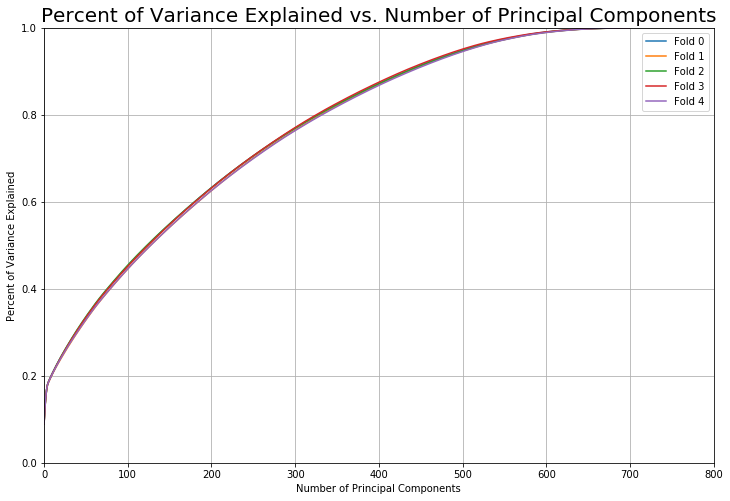

In [67]:
plt.figure(figsize=(12, 8))
for i, plot in enumerate(comp):
    plt.plot(plot, label='Fold %d' % i)
    
plt.grid()
plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('Percent of Variance Explained')
plt.ylim([0, 1])
plt.xlim([0, 800])
plt.title('Percent of Variance Explained vs. Number of Principal Components', fontsize=20)

Due to the nature of the categorical shooter and defender variables being so sparse, we cannot reduce the dimensionality by using PCA. 

Therefore, we will not use the shooter or the defender as a categorical variable. 

## Logistic Regression

We need to get rid of correlated predictors that contain redundant information for regression. 

SHOT_DIST and PTS_TYPE are very correlated with each other, so we will just consider SHOT_DIST. 

In [45]:
df_log = df_nba[['SHOT_NUMBER', 'SHOT_CLOCK', 'GAME_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'TOUCH_TIME', 'Very Tightly Defended', 'Tightly Defended', 'Open', 'Very Open', 'Completely Open']]

In [46]:
model = sm.Logit(df_nba['SHOT_RESULT'], df_log)

fit = model.fit()

fit.summary()

Optimization terminated successfully.
         Current function value: 0.658211
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            SHOT_RESULT   No. Observations:               126051
Model:                          Logit   Df Residuals:                   126040
Method:                           MLE   Df Model:                           10
Date:                Wed, 05 Dec 2018   Pseudo R-squ.:                 0.04412
Time:                        19:33:27   Log-Likelihood:                -82968.
converged:                       True   LL-Null:                       -86797.
                                        LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
SHOT_NUMBER               0.0030      0.001      2.362      0.018       0.001       0.006
SHOT_CLOCK                0.0174      0.001     17.174      0.000       0.015       0.019
GAME_CLOCK            -1.623e-05   2.88e-05     -0.564      0.573   -7.26e-05    4.02e-05
DRIBBLES                  0.0290      0.005      6.257      0.000       0.020       0.038
SHOT_DIST                -0.0668      0.001    -74.531      0.000      -0.069      -0.065
TOUCH_TIME               -0.0628      0.005    -11.555      0.000      -0.073      -0.052
Very Tightly Defended     0.0838      0.025      3.331      0.001       0.035       0.133
Tightly Defended          0.4937      0.025     19.952      0.000       0.445       0.542
Open                      0.8396      0.029     29.213      0.000       0.783       0.896
Very Open                 1.0040      0.032     31.269      0.000       0.941       1.067
Completely Open           1.1566      0.043     27.094      0.000       1.073       1.240
=========================================================================================
"""

Logistic Regression output a model with an $R^2$ of only 0.04, indicating that the predictors don't do a great job at predicting the chance it will go in. 

In [47]:
cv = list(model_selection.KFold(n_splits=5).split(df_model))
final_preds = []
for i, (train, test) in enumerate(cv):
    model = sm.Logit(df_nba.iloc[train]['SHOT_RESULT'], df_log.iloc[train])
    fit = model.fit()
    pred = fit.predict(df_log.iloc[test])
    
    # Find best threshold
    preds = []
    thresholds = np.arange(0, 1, 0.01)
    print("Fold %d" % i)
    gt = df_nba.iloc[test]['SHOT_RESULT']
    for t in thresholds: 
        transform = pred.apply(lambda x: 1 if x > t else 0)
        preds.append(accuracy_score(gt, transform))
    final_preds.append(preds)

Optimization terminated successfully.
         Current function value: 0.658136
         Iterations 5
Fold 0
Optimization terminated successfully.
         Current function value: 0.658326
         Iterations 5
Fold 1
Optimization terminated successfully.
         Current function value: 0.658102
         Iterations 5
Fold 2
Optimization terminated successfully.
         Current function value: 0.657900
         Iterations 5
Fold 3
Optimization terminated successfully.
         Current function value: 0.658486
         Iterations 5
Fold 4


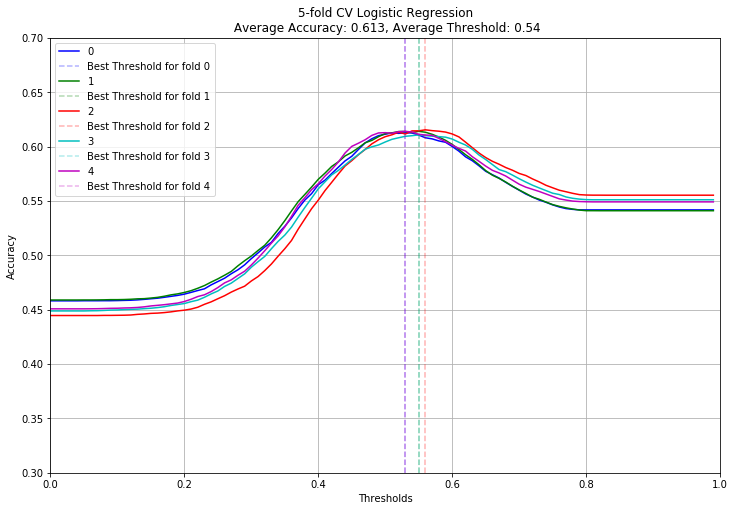

In [48]:
plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm']
res = []
for i, fold in enumerate(final_preds):
    plt.plot(np.arange(0, 1, 0.01), fold, label=i, color=colors[i])
    plt.axvline(np.argmax(fold)*0.01, linestyle='dashed', label="Best Threshold for fold %d" % i, color=colors[i], alpha=0.3)
    res.append((np.max(fold), np.argmax(fold)*0.01))
avg_acc = np.mean([x[0] for x in res])
avg_threshold = np.mean([x[1] for x in res])

plt.title('5-fold CV Logistic Regression\n Average Accuracy: %0.3f, Average Threshold: %0.2f' % (avg_acc, avg_threshold))
plt.legend()
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.xlim([0, 1])
plt.ylim([0.3, 0.7])
plt.grid()

Print out confusion matrix for each of the folds. 

In [49]:
lscores = []
lprecs = []
lrecs = []

for i, (train, test) in enumerate(cv):
    t = np.argmax(final_preds[i])*0.01
    acc = np.max(final_preds[i])
    model = sm.Logit(df_nba.iloc[train]['SHOT_RESULT'], df_log.iloc[train])
    fit = model.fit()
    pred = fit.predict(df_log.iloc[test])
    gt = df_nba.iloc[test]['SHOT_RESULT']
    transform = pred.apply(lambda x: 1 if x > t else 0)
    print("Fold %d Confusion Matrix" % i)
    print(confusion_matrix(gt, transform))
    print("Accuracy: %0.2f" % acc)
    prec = precision_score(gt, transform)
    print("Precision: %0.2f" % prec)
    rec = recall_score(gt, transform)
    print("Recall: %0.2f" % rec)
    lscores.append(acc)
    lprecs.append(prec)
    lrecs.append(rec)
    print("=============================================")

Optimization terminated successfully.
         Current function value: 0.658136
         Iterations 5
Fold 0 Confusion Matrix
[[11339  2321]
 [ 7443  4108]]
Accuracy: 0.61
Precision: 0.64
Recall: 0.36
Optimization terminated successfully.
         Current function value: 0.658326
         Iterations 5
Fold 1 Confusion Matrix
[[11771  1869]
 [ 7860  3710]]
Accuracy: 0.61
Precision: 0.66
Recall: 0.32
Optimization terminated successfully.
         Current function value: 0.658102
         Iterations 5
Fold 2 Confusion Matrix
[[12070  1930]
 [ 7764  3446]]
Accuracy: 0.62
Precision: 0.64
Recall: 0.31
Optimization terminated successfully.
         Current function value: 0.657900
         Iterations 5
Fold 3 Confusion Matrix
[[11709  2185]
 [ 7625  3691]]
Accuracy: 0.61
Precision: 0.63
Recall: 0.33
Optimization terminated successfully.
         Current function value: 0.658486
         Iterations 5
Fold 4 Confusion Matrix
[[11655  2190]
 [ 7539  3826]]
Accuracy: 0.61
Precision: 0.64
Recall: 

In [50]:
print("Average Accuracy: %0.3f" % np.mean(lscores))
print("Average Precision: %0.3f" % np.mean(lprecs))
print("Average Recall: %0.3f" % np.mean(lrecs))

Average Accuracy: 0.613
Average Precision: 0.642
Average Recall: 0.329


Logistic Regression yields on average ~62% accuracy, 63% precision, and 37% recall for this dataset, which is not great, but better than guessing, which would have a 55% accuracy.  

## Decision Trees

In [74]:
df_tree = df_nba[['SHOT_NUMBER', 'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'TOUCH_TIME', 'Very Tightly Defended', 'Tightly Defended', 'Open', 'Very Open', 'Completely Open']]

In [75]:
scores = []
precs = []
recs = []

for i, (train, test) in enumerate(cv):
    tree = xgboost.XGBClassifier()
    fit = tree.fit(df_tree.iloc[train], df_nba.iloc[train].SHOT_RESULT)
    pred = fit.predict(df_tree.iloc[test])
    gt = df_nba.iloc[test]['SHOT_RESULT']
    print("Fold %d Confusion Matrix" % i)
    print(confusion_matrix(gt, pred))
    score = accuracy_score(gt, pred)
    prec = precision_score(gt, pred)
    rec = precision_score(gt, pred)
    print("Accuracy: %0.3f" % score)
    print("Precision: %0.3f" % prec)
    print("Recall: %0.3f" % rec)
    scores.append(score)
    precs.append(prec)
    recs.append(rec)

/home/alexdai/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 0 Confusion Matrix
[[11738  1922]
 [ 7566  3985]]
Accuracy: 0.624
Precision: 0.675
Recall: 0.675


/home/alexdai/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 1 Confusion Matrix
[[11567  2073]
 [ 7514  4056]]
Accuracy: 0.620
Precision: 0.662
Recall: 0.662


/home/alexdai/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 2 Confusion Matrix
[[11677  2323]
 [ 7261  3949]]
Accuracy: 0.620
Precision: 0.630
Recall: 0.630


/home/alexdai/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 3 Confusion Matrix
[[11538  2356]
 [ 7275  4041]]
Accuracy: 0.618
Precision: 0.632
Recall: 0.632
Fold 4 Confusion Matrix
[[12005  1840]
 [ 7720  3645]]
Accuracy: 0.621
Precision: 0.665
Recall: 0.665


/home/alexdai/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [76]:
print("Average Accuracy: %0.3f" % np.mean(score))
print("Average Precision: %0.3f" % np.mean(precs))
print("Average Recall: %0.3f" % np.mean(recs))

Average Accuracy: 0.621
Average Precision: 0.652
Average Recall: 0.652
